Deep Learning T1-T2-ADC example - adapted from deep_ivim_demo

Code for unsupervised fitting of models to qMRI data.

Code is adapted from Barbieri et al. https://github.com/sebbarb/deep_ivim/blob/master/deep_ivim_demo.ipynb 


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import nibabel as nib


In [2]:
#define t1-t2-adc model
def t1t2adc(b,TE,ti,D,T2,T1):
    return abs(1 - (2*np.exp(-ti/T1)) + np.exp(-7.5/T1))*np.exp(-b*D) * np.exp(-(TE - np.min(TE))/T2)



#def ball(ti, t1_, bvals, lambda_iso):
#    return abs(1 - (2*np.exp(-ti/t1_)) + np.exp(-7.5/t1_))*np.exp(-bvals * lambda_iso) * np.exp(-(TE - np.min(TE))/T2)

#def stick(ti, t1_, bvals, lambda_par, n, mu):
#    return abs(1 - (2*np.exp(-ti/t1_)) + np.exp(-7.5/t1_))*np.exp(-bvals * lambda_par * np.dot(n, mu).transpose() ** 2) * np.exp(-(TE - np.min(TE))/T2)
        
#def ballstick(ti, t1_ball, t1_stick, bvals, lambda_iso, lambda_par, n, mu, Fp, s0):
#    return s0*(Fp*(ball(ti, t1_ball, bvals, lambda_iso)) + (1-Fp)*(stick(ti, t1_stick, bvals, lambda_par, n, mu)))
    
    

In [3]:
maskfile='/Users/paddyslator/Library/CloudStorage/OneDrive-UniversityCollegeLondon/data/cdmri-challenge-data/cdmri11_mask.nii'
imgfile='/Users/paddyslator/Library/CloudStorage/OneDrive-UniversityCollegeLondon/data/cdmri-challenge-data/cdmri11_r.nii'

imgnii = nib.load(imgfile)
masknii = nib.load(maskfile)

img = imgnii.get_data()
mask = masknii.get_data()




/var/folders/q9/yt6f867d3zq18ksrj75kk1fc0000gn/T/ipykernel_99874/472985112.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = imgnii.get_data()
/var/folders/q9/yt6f867d3zq18ksrj75kk1fc0000gn/T/ipykernel_99874/472985112.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = masknii.get_data()


In [4]:
imgdim = np.shape(img)
maskdim = np.shape(mask)

imgvox = np.reshape(img, (np.prod(imgdim[0:3]),imgdim[3]))
maskvox = np.reshape(mask, np.prod(imgdim[0:3]))

#train on the voxels in the mask 
X_train = imgvox[maskvox == 1]


#@Stefano X_train is nvox by nmeas - same as your .npy files 


In [5]:
gradechoinv = np.loadtxt('/Users/paddyslator/Library/CloudStorage/OneDrive-UniversityCollegeLondon/data/cdmri-challenge-data/gradechoinv.txt')

bvecs = gradechoinv[:,0:2]
bvals = gradechoinv[:,3]
te = gradechoinv[:,4]
ti = gradechoinv[:,5]

#convert to sensible units
#micrometre2/s
bvals = bvals * 1e-3
#seconds
ti = ti * 1e-3
te = te * 1e-3
#



In [6]:
#normalise

#find the volumes to normalise by - max ti, b=0
normvol = np.where(((bvals==min(bvals)) & (ti==max(ti)) & (te==min(te))))

nvol = np.shape(X_train)[1]

X_train = X_train/(np.tile(np.mean(X_train[:,normvol], axis=2),(1, nvol)))

In [7]:
#define the t1-t2-adc neural network

model='t1t2adc'

if model=='t1t2adc':
    nparams = 3
    class Net(nn.Module):
        def __init__(self, b_values, TE, TI  ):
            super(Net, self).__init__()

            self.b_values = b_values
            self.TE = TE
            self.TI = TI
            self.fc_layers = nn.ModuleList()
            for i in range(3): # 3 fully connected hidden layers
                self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
            self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), nparams))

        def forward(self, X):
            params = torch.abs(self.encoder(X)) # D, T2, T1
            D = params[:, 0].unsqueeze(1)
            T2 = params[:, 1].unsqueeze(1)
            T1 = params[:,2].unsqueeze(1)

    #        X = torch.exp(-self.b_values*D) * torch.exp(-(self.TE - torch.min(self.TE))/T2) 

            X = torch.abs(1 - (2*torch.exp(-self.TI/T1)) + torch.exp(-7.5/T1)) \
            * torch.exp(-self.b_values * D) \
            * torch.exp(-(self.TE - torch.min(self.TE))/T2)

            return X, D, T2, T1
    
    
    
    
# if model=='t1t2ballstick':  
#     nparams = 7
#     class Net(nn.Module):
#         def __init__(self,  b_values, TE, TI, bvecs):
#             super(Net, self).__init__()            
#             self.b_values = b_values
#             self.bvecs = bvecs
#             self.TE = TE
#             self.TI = TI            
            
#             self.fc_layers = nn.ModuleList()
#             for i in range(3): 
#                 self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
#             self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), nparams))
        
#         def forward(self, X):
# #             if args.dropout != 0:
# #                 X = self.dropout(X)
#             params = torch.abs(self.encoder(X))
#             t1_ball_uns = params[:, 0]
#             #t1_ball = squash(t1_ball_uns, 0.010, 5.0)
#             t1_stick_uns = params[:, 1]
#             #t1_stick = squash(t1_stick_uns, 0.010, 5.0)
#             lambda_par_uns = params[:, 2]
#             #lambda_par = squash(lambda_par_uns, 0.1, 3.0)
#             lambda_iso_uns = params[:, 3]
#             #lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
#             Fp = params[:,6].unsqueeze(1)
#             theta = params[:,4].unsqueeze(1)
#             phi = params[:,5].unsqueeze(1)
#             mu_cart = torch.zeros(3,X.size()[0])
#             sintheta = torch.sin(theta)
#             mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
#             mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
#             mu_cart[2,:] = torch.squeeze(torch.cos(theta))

#             mm_prod =  torch.einsum("ij,jk->ki",self.bvecs, mu_cart)
#             X = (Fp*(torch.abs(1 - (2*torch.exp(-self.TI/t1_ball)) + torch.exp(-7.5/t1_ball))*torch.exp(-self.b_values * lambda_iso)) + (1-Fp)*(torch.abs(1 - (2*torch.exp(-self.TI/t1_stick)) + torch.exp(-7.5/t1_stick))*torch.exp(-self.b_values * lambda_par * mm_prod ** 2)))
#             return X, t1_ball, t1_stick, lambda_par, lambda_iso, mu_cart, Fp

In [8]:
# make the Network
#b_values_no0 = torch.FloatTensor(b_values[1:])
#TE_nomin = torch.FloatTensor(TE[1:])

b_values_tor = torch.FloatTensor(bvals)
TE_tor = torch.FloatTensor(te)
TI_tor = torch.FloatTensor(ti)
bvecs_tor = torch.FloatTensor(bvecs)

if model=='t1t2adc':
    net = Net(b_values_tor, TE_tor, TI_tor)
if model=='t1t2ballstick': 
    net = Net(b_values_tor, TE_tor, TI_tor, bvecs_tor)


# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)  

In [9]:
#create batch queues
batch_size = 128
num_batches = len(X_train) // batch_size

#X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized

trainloader = utils.DataLoader(torch.from_numpy(X_train.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [10]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

# Train
for epoch in range(100): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        X_pred, D_pred, T2_pred, T1_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.47it/s]


Loss: 6.823992525693029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 52.00it/s]


Loss: 5.12831146735698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 49.83it/s]


Loss: 5.073934702202678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.49it/s]


Loss: 4.977178189437836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 52.13it/s]


Loss: 5.045801188331097
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.63it/s]


Loss: 5.075185126625001
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.13it/s]


Loss: 4.7748563517816365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 52.08it/s]


Loss: 4.824548278003931
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.86it/s]


Loss: 4.722924564033747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 52.05it/s]


Loss: 4.648040525615215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.92it/s]


Loss: 4.6561682699248195
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.47it/s]


Loss: 4.647788678761572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.65it/s]


Loss: 4.653298289515078
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.49it/s]


Loss: 4.594094066880643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.68it/s]


Loss: 4.618680567480624
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.60it/s]


Loss: 4.558798237703741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.65it/s]


Loss: 4.618804765399545
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.48it/s]


Loss: 4.612812910228968
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.10it/s]


Loss: 4.504700753837824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:14<00:00, 46.31it/s]


Loss: 4.620338259730488
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 48.77it/s]


Loss: 4.531538409180939
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.29it/s]


Loss: 4.519070769194514
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.18it/s]


Loss: 4.813208943232894
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.27it/s]


Loss: 5.214880081359297
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.68it/s]


Loss: 4.575894568581134
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.06it/s]


Loss: 4.506206856574863
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 49.83it/s]


Loss: 4.5600950489751995
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 48.29it/s]


Loss: 4.510272386483848
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.99it/s]


Loss: 4.495920590590686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.82it/s]


Loss: 4.604339582845569
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:14<00:00, 46.90it/s]


Loss: 4.7913599433377385
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 49.79it/s]


Loss: 4.597615704871714
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 50.35it/s]


Loss: 4.4959924863651395
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.90it/s]


Loss: 4.495368516538292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.38it/s]


Loss: 4.512277237139642
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.64it/s]


Loss: 4.641505212523043
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 52.01it/s]


Loss: 4.51179529633373
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.63it/s]


Loss: 4.519563760608435
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 52.03it/s]


Loss: 4.641720829065889
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.77it/s]


Loss: 4.502028169576079
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.64it/s]


Loss: 4.48694196017459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.87it/s]


Loss: 4.500735325273126
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.63it/s]


Loss: 4.464659768156707
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 50.66it/s]


Loss: 4.502526585943997
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.45it/s]


Loss: 4.539484527893364
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.95it/s]


Loss: 4.491437999065965
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.54it/s]


Loss: 4.514112256001681
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.92it/s]


Loss: 4.497148831374943
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.58it/s]


Loss: 4.523532126098871
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.17it/s]


Loss: 4.515084098093212
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.80it/s]


Loss: 4.520810042042285
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.75it/s]


Loss: 4.533642782829702
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████| 657/657 [00:12<00:00, 51.72it/s]

Loss: 4.5292896893806756
Done, best loss: 4.464659768156707
Done


<All keys matched successfully>

In [11]:
#Inference

net.eval()
with torch.no_grad():
    X_pred, D, T2, T1 = net(torch.from_numpy(X_train.astype(np.float32)))
    
D = D.numpy()
T2 = T2.numpy()
T1 = T1.numpy()




    

In [12]:
# #reshape back into image 

D_vox = np.zeros(np.shape(maskvox))
D_vox[maskvox==1] = np.squeeze(D[:])
D_map = np.reshape(D_vox,np.shape(mask))

T2_vox = np.zeros(np.shape(maskvox))
T2_vox[maskvox==1] = np.squeeze(T2[:])
T2_map = np.reshape(T2_vox,np.shape(mask))

T1_vox = np.zeros(np.shape(maskvox))
T1_vox[maskvox==1] = np.squeeze(T1[:])
T1_map = np.reshape(T1_vox,np.shape(mask))



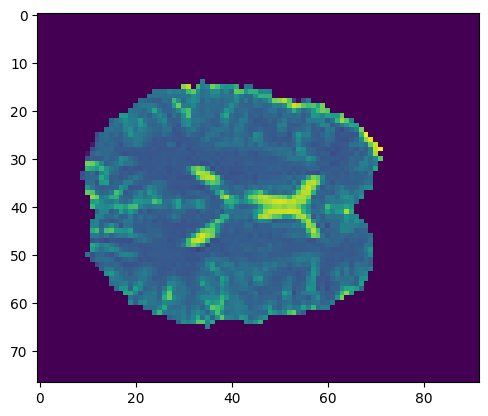

In [19]:
plt.imshow(T1_map[:,:,30])